In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
DATA_PATH = "../data/"
train_data = pd.read_json(f"{DATA_PATH}polygons.jsonl", lines=True)
test_data = pd.read_json(f"{DATA_PATH}polygons.jsonl", lines=True)

ValueError: Expected object or value

In [ ]:
print("hi")

In [8]:
df_flattened = train_data.explode('annotations')
temp_df = df_flattened['annotations'].apply(pd.Series)
poly_df = pd.concat([train_data['id'], temp_df], axis=1)
poly_df.reset_index(inplace=True, drop=True)
poly_df.head(20)

,id,type,coordinates
0,0006ff2aa7cd,glomerulus,"[[[167, 249], [166, 249], [165, 249], [164, 24..."
1,0006ff2aa7cd,blood_vessel,"[[[283, 109], [282, 109], [281, 109], [280, 10..."
2,0006ff2aa7cd,blood_vessel,"[[[104, 292], [103, 292], [102, 292], [101, 29..."
3,0006ff2aa7cd,blood_vessel,"[[[505, 442], [504, 442], [503, 442], [502, 44..."
4,0006ff2aa7cd,blood_vessel,"[[[375, 477], [374, 477], [373, 477], [372, 47..."
5,0006ff2aa7cd,blood_vessel,"[[[368, 410], [367, 410], [366, 410], [365, 41..."
6,0006ff2aa7cd,blood_vessel,"[[[339, 249], [338, 249], [337, 249], [336, 24..."
7,0006ff2aa7cd,blood_vessel,"[[[352, 67], [351, 67], [350, 67], [349, 67], ..."
8,0006ff2aa7cd,blood_vessel,"[[[227, 299], [226, 299], [225, 299], [224, 29..."
9,00168d1b7522,glomerulus,"[[[511, 216], [511, 216], [510, 216], [509, 21..."


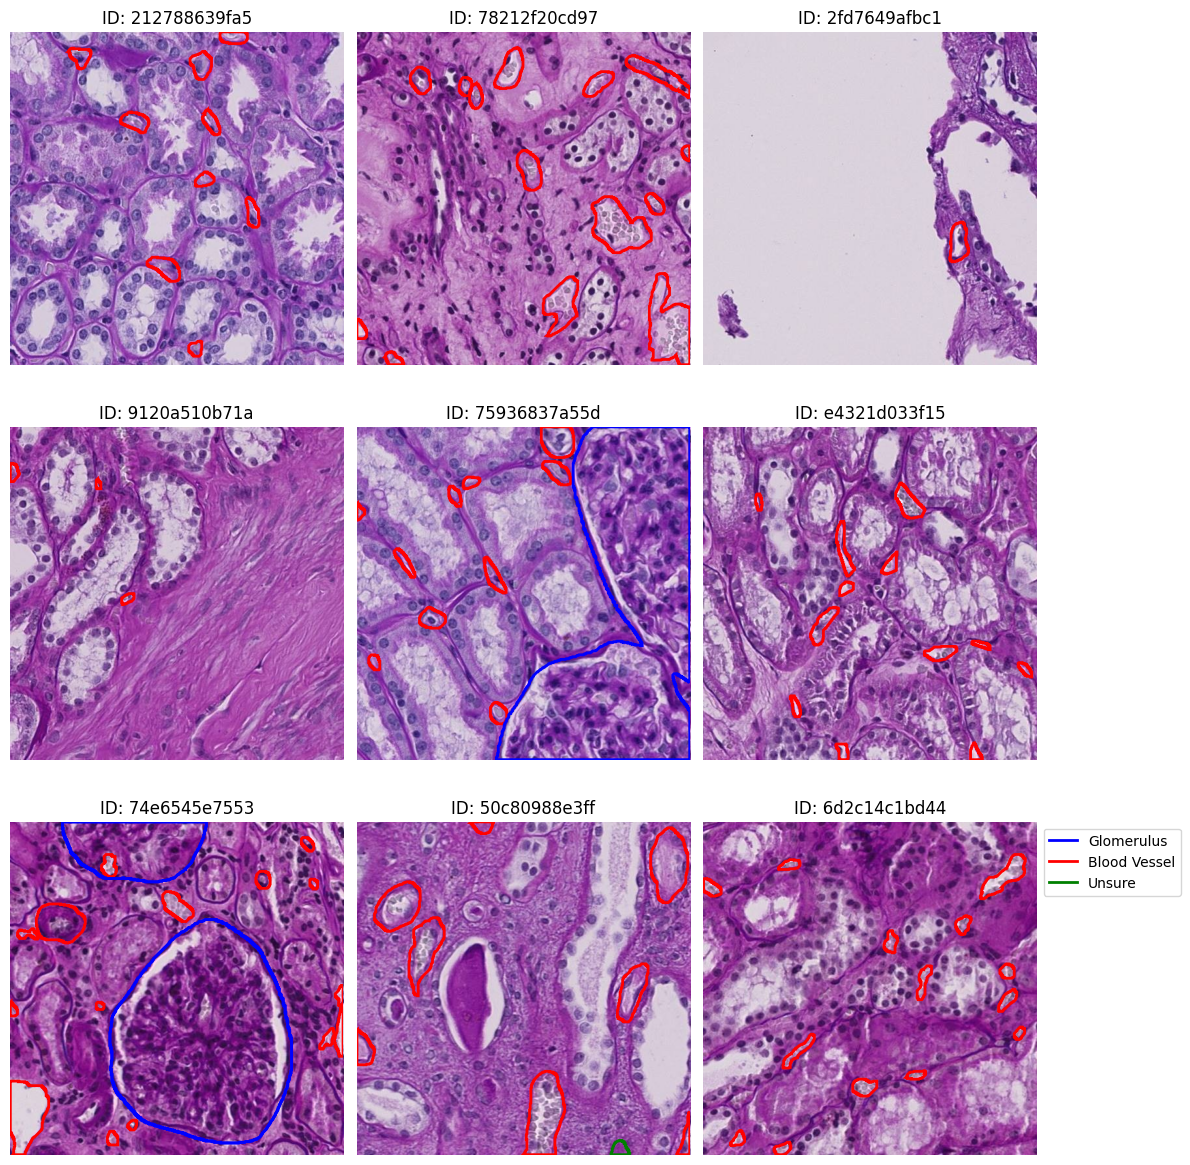

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image

def plot_image_with_masks(df):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    unique_ids = df['id'].unique()
    if len(unique_ids) < 9:
        sampled_ids = np.random.choice(unique_ids, size=9, replace=True)
    else:
        sampled_ids = np.random.choice(unique_ids, size=9, replace=False)

    for i, image_id in enumerate(sampled_ids):
        image_path = f"{DATA_PATH}/train/{image_id}.tif"
        image = np.array(Image.open(image_path))

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')

        # Get the masks for the current image ID
        masks = df[df['id'] == image_id]

        # Plot the polygon masks
        for _, row in masks.iterrows():
            mask_type = row['type']
            coordinates = row['coordinates']
            color = get_mask_color(mask_type)
            for coord in coordinates:
                polygon = Polygon(coord, closed=True, edgecolor=color, linewidth=2, fill=False)
                axes[i].add_patch(polygon)

        # Set the title as the image ID
        axes[i].set_title(f"ID: {image_id}")

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', linewidth=2, label='Glomerulus'),
        plt.Line2D([0], [0], color='red', linewidth=2, label='Blood Vessel'),
        plt.Line2D([0], [0], color='green', linewidth=2, label='Unsure')
    ]
    axes[-1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

def get_mask_color(mask_type):
    if mask_type == 'glomerulus':
        return 'blue'
    elif mask_type == 'blood_vessel':
        return 'red'
    elif mask_type == 'unsure':
        return 'green'
    else:
        return 'black'  # Default color if mask type is unknown

# Call the function with your dataframe
plot_image_with_masks(poly_df)

In [23]:
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torch.nn as nn
import torch.nn.functional as F
import torch

# Mask R-CNN Model

In [25]:
class MaskRCNN(nn.Module):
    def __init__(self, num_classes):
        super(MaskRCNN, self).__init__()
        
        self.model = maskrcnn_resnet50_fpn(pretrained=True)
        
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
        
    def forward(self, images, targets=None):
        return self.model(images, targets)
    
    def train_model(self, train_loader, optimizer, device, num_epochs):
        self.model.to(device)
        self.model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for images, masks, labels in train_loader:
                images = images.to(device)
                masks = masks.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = self.model(images)
                loss = self.model.get_loss(outputs, masks, labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

        print("Training complete.")

    def get_loss(self, outputs, masks, labels, loss_type='bce'):
        if loss_type == 'bce':
            loss = self.binary_cross_entropy_loss(outputs, masks, labels)
        elif loss_type == 'dice':
            loss = self.dice_loss(outputs, masks, labels)
        else:
            raise ValueError("Invalid loss type. Supported loss types are 'bce' and 'dice'.")
        
        return loss
    
    def binary_cross_entropy_loss(self, outputs, masks, labels):
        mask_logits = outputs['masks']
        mask_targets = masks.float()
        loss = F.binary_cross_entropy_with_logits(mask_logits, mask_targets)
        
        return loss
    
    def dice_loss(self, outputs, masks, labels):
        mask_logits = outputs['masks']
        mask_targets = masks.float()
        mask_probs = torch.sigmoid(mask_logits)
        
        smooth = 1e-5
        intersection = (mask_probs * mask_targets).sum(dim=(2, 3))
        union = mask_probs.sum(dim=(2, 3)) + mask_targets.sum(dim=(2, 3))
        dice_scores = (2.0 * intersection + smooth) / (union + smooth)
        loss = 1 - dice_scores.mean()
        
        return loss

# Custom predictor for the classification layer
class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        
        self.fc = nn.Linear(in_channels, num_classes)
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Custom predictor for the mask layer
class MaskRCNNPredictor(nn.Sequential):
    def __init__(self, in_channels, hidden_dim, num_classes):
        super(MaskRCNNPredictor, self).__init__(
            nn.ConvTranspose2d(in_channels, hidden_dim, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, num_classes, kernel_size=1, stride=1)
        )

In [28]:
#TODO: Setup Cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Losses
- **Binary Cross-Entropy Loss**
- **Dice Loss**

In [ ]:
model = MaskRCNN(num_classes=3)  #3 classes: blood_vessel, glomerulus, unsure
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_df, data_path, transform=None):
        self.data_df = data_df
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        img_id = self.data_df.loc[idx, 'id']
        img_type = self.data_df.loc[idx, 'type']
        img_path = self.data_path + img_id + '.tif'
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_type
    
# Define data paths
DATA_PATH = "../data/"
TRAIN_PATH = DATA_PATH + "train/"
VAL_PATH = DATA_PATH + "test/"

train_ratio = 0.8  # 80% of data for training, 20% for validation
train_size = int(train_ratio * len(poly_df))
train_data = poly_df[:train_size]
val_data = poly_df[train_size:]

# Define transforms
transform = ToTensor()

# Create training and validation datasets
train_dataset = CustomDataset(train_data, TRAIN_PATH, transform)
val_dataset = CustomDataset(test_data, VAL_PATH, transform)

# Define batch size for data loaders
batch_size = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Calculate the number of classes
num_classes = len(train_data['type'].unique())


In [13]:
##########################

# Test implementing it on our own

In [14]:
import torch
import torch.nn as nn

# Region Proposal Network (RPN)
class RPN(nn.Module):
    def __init__(self, in_channels, mid_channels, num_anchors):
        super(RPN, self).__init__()
        
        self.num_anchors = num_anchors
        
        # Convolutional layer for intermediate features
        self.conv = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        
        # Classification head
        self.cls_head = nn.Conv2d(mid_channels, num_anchors * 2, kernel_size=1, stride=1)
        
        # Regression head
        self.reg_head = nn.Conv2d(mid_channels, num_anchors * 4, kernel_size=1, stride=1)
        
        # Initialize the weights
        self._init_weights()
    
    def _init_weights(self):
        nn.init.normal_(self.conv.weight, std=0.01)
        nn.init.constant_(self.conv.bias, 0)
        nn.init.normal_(self.cls_head.weight, std=0.01)
        nn.init.constant_(self.cls_head.bias, 0)
        nn.init.normal_(self.reg_head.weight, std=0.01)
        nn.init.constant_(self.reg_head.bias, 0)
        
    def forward(self, features):
        # RPN forward pass
        x = self.conv(features)
        
        # Classification scores
        rpn_logits = self.cls_head(x)
        rpn_logits = rpn_logits.permute(0, 2, 3, 1).contiguous()
        rpn_logits = rpn_logits.view(features.size(0), -1, 2)
        
        # Bounding box regression
        rpn_bbox = self.reg_head(x)
        rpn_bbox = rpn_bbox.permute(0, 2, 3, 1).contiguous()
        rpn_bbox = rpn_bbox.view(features.size(0), -1, 4)
        
        return rpn_logits, rpn_bbox


In [15]:
import torch
import torch.nn as nn
import torchvision.ops as ops

# RoI (Region of Interest) align layer
class RoIAlign(nn.Module):
    def __init__(self, output_size, spatial_scale):
        super(RoIAlign, self).__init__()
        
        self.output_size = output_size
        self.spatial_scale = spatial_scale
        
    def forward(self, features, rpn_bbox):
        # RoI align forward pass
        rois = self._generate_rois(rpn_bbox, features.size(2), features.size(3))
        
        # RoI align operation
        roi_features = ops.roi_align(features, rois, self.output_size, self.spatial_scale)
        
        return rois, roi_features
    
    def _generate_rois(self, rpn_bbox, image_height, image_width):
        batch_size = rpn_bbox.size(0)
        num_rois = rpn_bbox.size(1)
        
        # Convert normalized coordinates to absolute coordinates
        x1 = rpn_bbox[:, :, 0] * image_width
        y1 = rpn_bbox[:, :, 1] * image_height
        x2 = rpn_bbox[:, :, 2] * image_width
        y2 = rpn_bbox[:, :, 3] * image_height
        
        rois = torch.stack([x1, y1, x2, y2], dim=2)
        rois = rois.view(batch_size, num_rois, 4)
        
        return rois

In [16]:
import torch
import torch.nn as nn

# Region-based convolutional network (RCNN)
class RCNN(nn.Module):
    def __init__(self, num_classes, feature_dim=256):
        super(RCNN, self).__init__()
        
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        
        # RoI pooling layer
        self.roi_pool = nn.AdaptiveMaxPool2d((7, 7))
        
        # Fully connected layers for classification and bounding box regression
        self.fc_cls = nn.Linear(feature_dim * 7 * 7, num_classes)
        self.fc_reg = nn.Linear(feature_dim * 7 * 7, num_classes * 4)
        
        # Mask prediction branch
        self.mask_branch = MaskBranch(feature_dim)
        
        # Initialize the weights
        self._init_weights()
        
    def _init_weights(self):
        nn.init.normal_(self.fc_cls.weight, std=0.01)
        nn.init.constant_(self.fc_cls.bias, 0)
        nn.init.normal_(self.fc_reg.weight, std=0.01)
        nn.init.constant_(self.fc_reg.bias, 0)
        
    def forward(self, proposal_features, targets=None):
        # RCNN forward pass
        rois = proposal_features.rois
        
        # RoI pooling
        pooled_features = self.roi_pool(proposal_features.features, rois)
        flattened_features = torch.flatten(pooled_features, start_dim=1)
        
        # Classification and bounding box regression
        rcnn_cls = self.fc_cls(flattened_features)
        rcnn_reg = self.fc_reg(flattened_features)
        
        rcnn_cls = rcnn_cls.view(-1, self.num_classes)
        rcnn_reg = rcnn_reg.view(-1, self.num_classes, 4)
        
        if self.training:
            # Calculate the RCNN loss and refine the proposals
            rcnn_masks = self.mask_branch(pooled_features, rois, targets)
            return rcnn_cls, rcnn_reg, rcnn_masks
        
        else:
            # Return the predicted bounding boxes and masks
            return rcnn_cls, rcnn_reg, None


# Mask prediction branch
class MaskBranch(nn.Module):
    def __init__(self, feature_dim):
        super(MaskBranch, self).__init__()
        
        self.feature_dim = feature_dim
        
        # Fully connected layer for mask prediction
        self.fc_mask = nn.Linear(feature_dim * 7 * 7, feature_dim)
        
        # Mask prediction
        self.mask_prediction = nn.Conv2d(feature_dim, 1, kernel_size=1, stride=1)
        
        # Initialize the weights
        self._init_weights()
        
    def _init_weights(self):
        nn.init.normal_(self.fc_mask.weight, std=0.01)
        nn.init.constant_(self.fc_mask.bias, 0)
        nn.init.normal_(self.mask_prediction.weight, std=0.01)
        nn.init.constant_(self.mask_prediction.bias, 0)
        
    def forward(self, pooled_features, rois, targets):
        # Mask prediction forward pass
        flattened_features = torch.flatten(pooled_features, start_dim=1)
        fc_mask = self.fc_mask(flattened_features)
        fc_mask = fc_mask.view(fc_mask.size(0), self.feature_dim, 7, 7)
        
        mask_prediction = self.mask_prediction(fc_mask)
        
        # Upsample the mask predictions to the original RoI size
        rois = rois.unsqueeze(2).unsqueeze(3)
        mask_prediction = nn.functional.interpolate(mask_prediction, size=(rois.size(2), rois.size(3)), mode='bilinear', align_corners=False)
        mask_prediction = mask_prediction.squeeze(1)
        
        # Generate binary masks using sigmoid activation
        mask_prediction = torch.sigmoid(mask_prediction)
        
        return mask_prediction

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Mask R-CNN network architecture
class MaskRCNN(nn.Module):
    def __init__(self, num_classes):
        super(MaskRCNN, self).__init__()
        
        # Backbone network (e.g., ResNet)
        self.backbone = torchvision.models.resnet50(pretrained=True)
        
        # Region Proposal Network (RPN)
        self.rpn = RPN()
        
        # RoI (Region of Interest) align layer
        self.roi_align = RoIAlign()
        
        # Region-based convolutional network (RCNN)
        self.rcnn = RCNN(num_classes)
        
    def forward(self, images, targets=None):
        # Backbone network
        features = self.backbone(images)
        
        # Region Proposal Network (RPN)
        rpn_logits, rpn_bbox = self.rpn(features)
        
        # Generate proposals and their corresponding RoI features
        proposals, proposal_features = self.roi_align(features, rpn_bbox)
        
        if self.training:
            # During training, calculate the RCNN loss and refine the proposals
            rcnn_logits, rcnn_bbox, rcnn_masks = self.rcnn(proposal_features, targets)
            return rpn_logits, rpn_bbox, rcnn_logits, rcnn_bbox, rcnn_masks
        
        else:
            # During inference, return the predicted bounding boxes and masks
            rcnn_logits, rcnn_bbox, rcnn_masks = self.rcnn(proposal_features)
            return rcnn_logits, rcnn_bbox, rcnn_masks